# GPCP Rainfall Frequency Analysis with Xhistogram

The goal here is to demonstrate how simple it is to calculate probability distributions from xarray data using [xhistogram](https://xhistogram.readthedocs.io/en/latest/).

In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

import intake
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from xhistogram.xarray import histogram
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  
plt.rcParams['figure.figsize'] = 12, 6

### Reference Calculation

We are basically trying to reproduce a calculation by [Angie Pendegrass](https://staff.ucar.edu/users/apgrass) described on the NCAR website: <https://climatedataguide.ucar.edu/climate-data/gpcp-daily-global-precipitation-climatology-project>

![gpcp_histogram](https://climatedataguide.ucar.edu/sites/default/files/styles/node_key_figures_display/public/key_figures/climate_data_set/cdgbutterflygpcp.jpg?itok=RnJ_w-ge)

> Rain frequency distribution at each latitude in GPCP 1DD data, 1997-2013. Left: dry day frequency (%). Right: Rain frequency with logarithmically-spaced rain rate bins. Units are percent per increment of rain rate, so evenly spaced increments of rain rate can be compared. Abrupt transitions between 40 and 50 N are features in the product which occur due to the transition in data sources across this latitude band.

Angie offered some clarification about how it was produced in a personal communcation:

> For these I cacluated the distribution at each point and then took the zonal mean. I have some python code for how I calculate distributions of precip here: https://github.com/apendergrass/rain-metrics-python - `raindistdemo.py` is the relevant one, it calculates pointwise distributions, and then you can take the zonal mean... The units are set up such that when you sum up the whole histogram it gives you the fraction of days with nonzero precip. If you also add the dry day fraction, it gets you to 100%. This entails normalizing by the spacing of the bins.

For reference, [`raindistdemo.py`](https://github.com/apendergrass/rain-metrics-python/blob/master/raindistdemo.py) has about 100 lines of code (excluding comments) and is written in what I would call MATLAB-style python. One goal of this demo is to illustrate how such calculations can be a lot simpler using high-level python tools.

## Loading the Data

First we load the GPCP data from the [Pangeo cloud datastore](https://pangeo-data.github.io/pangeo-datastore/). Note that it uses "lazy loading," represeting the data as dask arrays. 

In [2]:
cat_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml'
master_cat = intake.Catalog(cat_url)
gpcp = master_cat.atmosphere.gpcp_cdr_daily_v1_3.to_dask()
gpcp

<xarray.Dataset>
Dimensions:      (latitude: 180, longitude: 360, nv: 2, time: 8069)
Coordinates:
    lat_bounds   (time, latitude, nv) float32 dask.array<shape=(8069, 180, 2), chunksize=(8069, 180, 2)>
  * latitude     (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
    lon_bounds   (time, longitude, nv) float32 dask.array<shape=(8069, 360, 2), chunksize=(8069, 360, 2)>
  * longitude    (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 1997-01-01 00:00:00 ... 2018-12-31 00:00:00
    time_bounds  (time, nv) object dask.array<shape=(8069, 2), chunksize=(8069, 2)>
Dimensions without coordinates: nv
Data variables:
    precip       (time, latitude, longitude) float32 dask.array<shape=(8069, 180, 360), chunksize=(517, 180, 360)>
Attributes:
    Conventions:                CF-1.6, ACDD 1.3
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    acknowledgment:             This project was supported in pa

We can also get a nice visual summary of the underlying dask arrays:

In [3]:
gpcp.precip.data

dask.array<zarr, shape=(8069, 180, 360), dtype=float32, chunksize=(517, 180, 360)>

## Reproducing the Calculation

### Define the Bins

It's important to note the units of rainfall in the dataset.

In [4]:
gpcp.precip.units

'mm/day'

Angie's histogram used logarithmically spaced bins, plus a "special" bin for dry days. Since there is no such thing as zero in floating point data, we will define a bin with range `[0, 0.01]` as our "dry" bin. We can create such bins as follows.

In [5]:
# the units here are mm/day
nbins = 100
bins = np.hstack([[0], np.logspace(-2, 2, nbins)])
bins[:4] # peek at the first four bins

array([0.        , 0.01      , 0.01097499, 0.01204504])

It will also be important to define the bin spacing in log space, since this is how Angie normalized her values.

In [6]:
bin_spacing = np.diff(np.log(bins))
bin_spacing[:4]

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([       inf, 0.09303374, 0.09303374, 0.09303374])

After the first special bin, the bins are spaced evenly in log space, as `np.logspace` is supposed to do.

### Histogram 3 Ways

Calculating the histogram with xhistogram is really easy. In the example below, we calculate the "raw" histogram (no normalization) over the time and longitude dimensions, leaving the latitude dimension intact. (The time here includes loading the data over the network, plus computing time.)

In [7]:
%time gpcp_hist = histogram(gpcp.precip, bins=[bins], dim=['time', 'longitude']).load()

CPU times: user 33.5 s, sys: 17 s, total: 50.6 s
Wall time: 31.3 s


In that code, we just counted the number of points in the array falling in each bin.

But is that what Angie did? In her words:

> For these I cacluated the distribution [over time] at each point and then took the zonal mean

That would be more like:

In [8]:
%time gpcp_hist_time = histogram(gpcp.precip, bins=[bins], dim=['time']).mean(dim='longitude').load()

CPU times: user 39.9 s, sys: 10.8 s, total: 50.7 s
Wall time: 30.1 s


There is a third possibility: take the histogram over longitude and then take the mean in time.

In [9]:
%time gpcp_hist_lon = histogram(gpcp.precip, bins=[bins], dim=['longitude']).mean(dim='time').load()

CPU times: user 31.7 s, sys: 7.48 s, total: 39.1 s
Wall time: 23 s


That one was actually the fastest, because it aligns most easily with the chunks of the dask array.

Do they give the same answer? Let's look at the results.

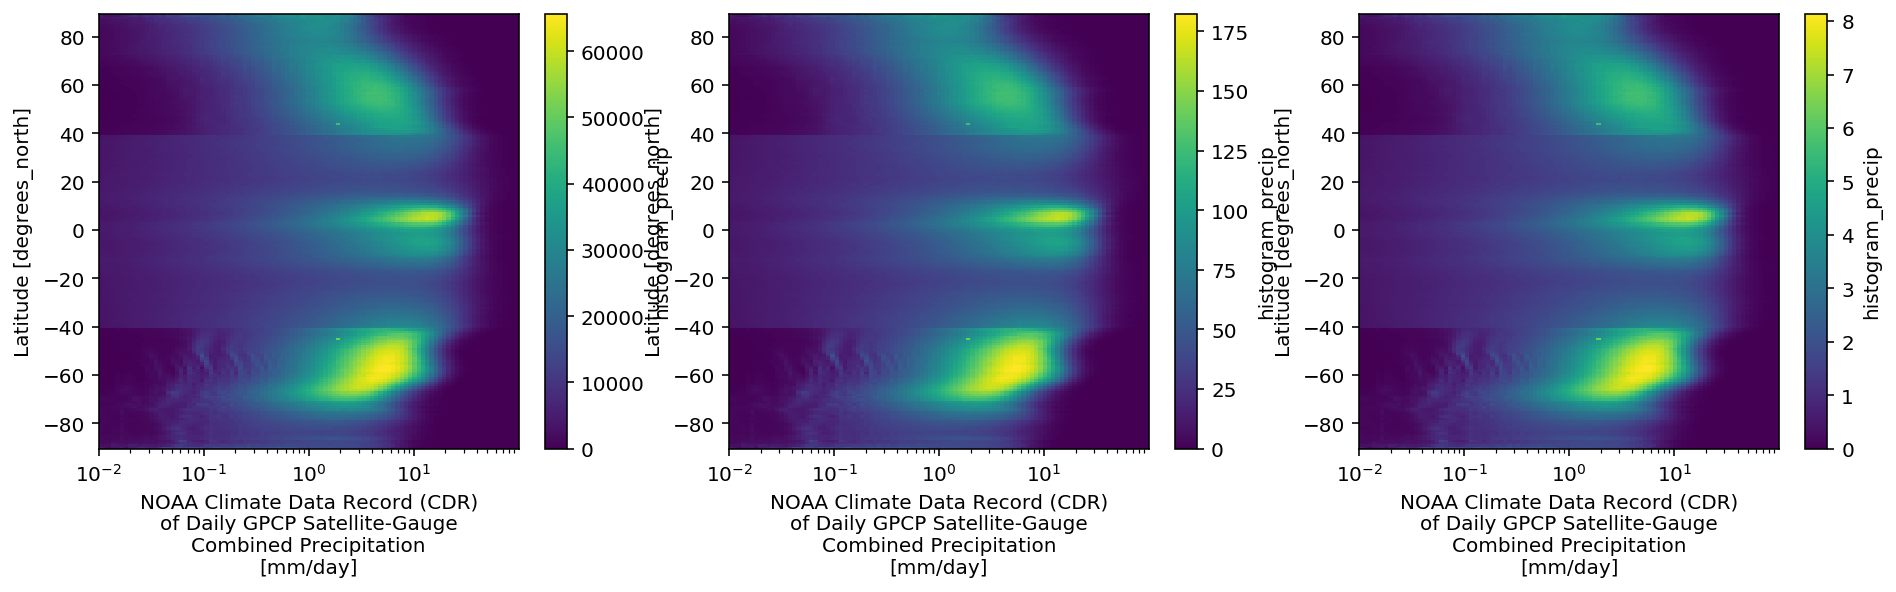

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

# the indexing [:, 1:] skips the "dry bin"
gpcp_hist[:, 1:].plot(ax=axes[0], xscale='log')
gpcp_hist_time[:, 1:].plot(ax=axes[1], xscale='log')
gpcp_hist_lon[:, 1:].plot(ax=axes[2], xscale='log')

It's clear from the visualization that the only difference here is a normalization factor. The first case is a sum over *all* the bins. The second is a sum over bins in time and a mean in longitude, while the third is a sum over bins in longitude and a mean in time. In each case, all the rows sum to the total number of points.

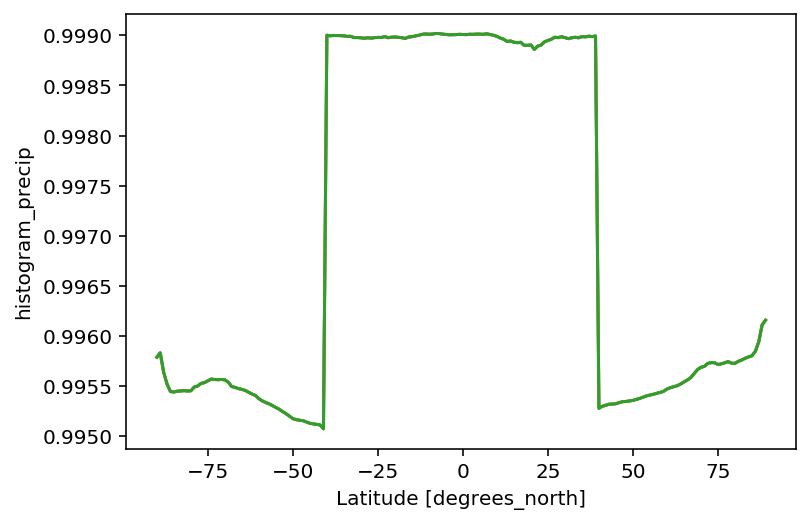

In [11]:
(gpcp_hist.sum(dim='precip_bin') / (gpcp.dims['longitude'] * gpcp.dims['time'])).plot()
(gpcp_hist_lon.sum(dim='precip_bin') / (gpcp.dims['longitude'])).plot()
(gpcp_hist_time.sum(dim='precip_bin') / (gpcp.dims['time'])).plot()

These don't quite all equal one because our bins evidently did not cover all values that appear in the dataset. But it's good enough.

Since we verified they all give the same answer, we are free to use the most efficient version:

    gpcp_hist_lon = histogram(gpcp.precip, bins=[bins], dim=['longitude']).mean(dim='time')

### Normalizing

> The units are set up such that when you sum up the whole histogram it gives you the fraction of days with nonzero precip. If you also add the dry day fraction, it gets you to 100%. This entails normalizing by the spacing of the bins.

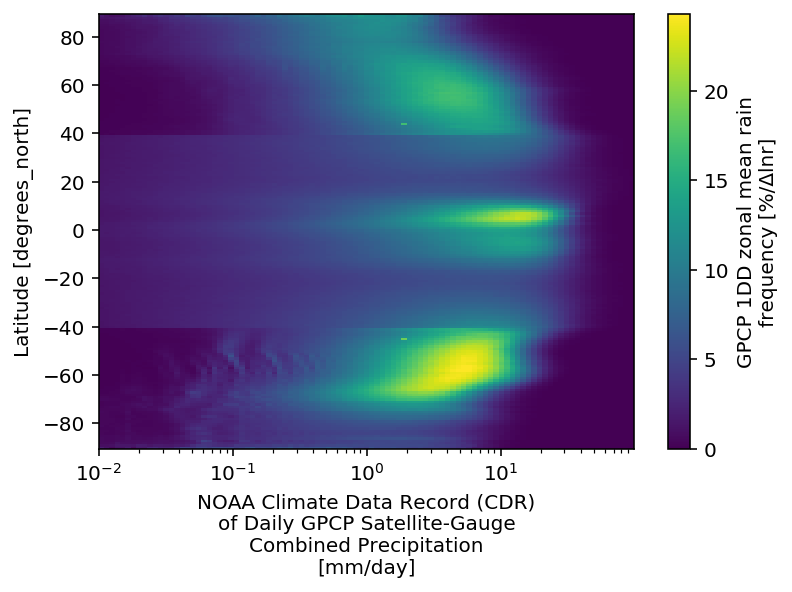

In [13]:
npoints = gpcp.dims['longitude']

gpcp_hist_norm = gpcp_hist_lon[:, 1:] * 100 / (npoints * bin_spacing[1])
gpcp_hist_norm.attrs.update({'long_name': 'GPCP 1DD zonal mean rain frequency',
                             'units': '%/Δlnr'})

gpcp_dry_norm = gpcp_hist_lon[:, 0] * 100 / npoints
gpcp_dry_norm.attrs.update({'long_name': 'r=0',
                             'units': '%'})
gpcp_hist_norm.plot(xscale='log')

That's the same order of magnitude as Angie's figure.

## Reproducing the Plot

In order to reproduce the plot exactly, we need a few more details, such as

- sine(latitude) y scale
- pretty subplots

To do the sine latitude scaling, I've done it the "right" way, by creating a custom scale object. This unfortunately requires some complex custom code which I basically just copied and modified slightly from the matplotlib documentation.

In [14]:
# adapted from https://matplotlib.org/gallery/api/custom_scale_example.html

from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator

import warnings
warnings.filterwarnings("always")

class SineLatitudeScale(mscale.ScaleBase):

    name = 'sinelat'

    def __init__(self, axis):
        mscale.ScaleBase.__init__(self, axis)

    def get_transform(self):
        return self.SineLatitudeTransform()

    def set_default_locators_and_formatters(self, axis):
        class DegreeFormatter(Formatter):
            def __call__(self, x, pos=None):
                return "%d\N{DEGREE SIGN}" % x

        axis.set_major_locator(FixedLocator(np.arange(-90, 91, 30)))
        axis.set_major_formatter(DegreeFormatter())
        axis.set_minor_formatter(DegreeFormatter())

    class SineLatitudeTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
        has_inverse = True

        def __init__(self):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return np.sin(np.deg2rad(a))

        def inverted(self):
            return SineLatitudeScale.InvertedSineLatitudeTransform()

    class InvertedSineLatitudeTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
        has_inverse = True

        def __init__(self):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return np.rad2deg(np.arcsin(a))

        def inverted(self):
            return SineLatitudeScale.SineLatitudeTransform()

mscale.register_scale(SineLatitudeScale)

We can now use this scale with any axis.

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in arcsin


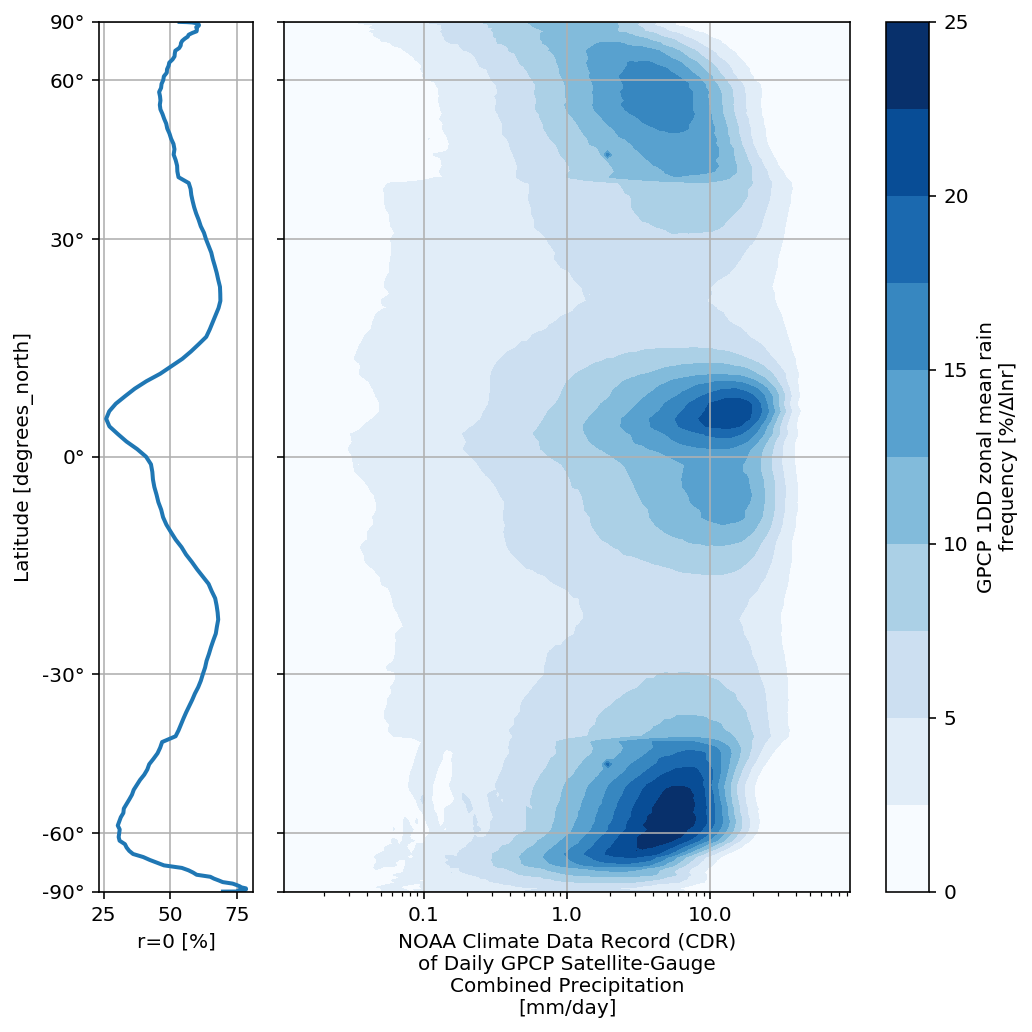

In [15]:
fig = plt.figure(figsize=(8, 8))

ax0 = plt.subplot2grid((1, 5), (0, 0))
ax1 = plt.subplot2grid((1, 5), (0, 1), colspan=4)

gpcp_dry_norm.plot(y='latitude', ax=ax0, lw=2)
ax0.set_yscale('sinelat')
ax0.set_ylim([-90, 90])
ax0.grid(True)
ax0.set_title(None)

gpcp_hist_norm.plot.contourf(ax=ax1, levels=np.arange(0, 26, 2.5),
                             cmap='Blues', xscale='log')
ax1.set_yscale('sinelat')
ax1.set_ylim([-90, 90])
ax1.set_yticklabels([])
ax1.set_ylabel(None)
ax1.grid(True)
from matplotlib.ticker import ScalarFormatter
ax1.xaxis.set_major_formatter(ScalarFormatter())

![gpcp_histogram](https://climatedataguide.ucar.edu/sites/default/files/styles/node_key_figures_display/public/key_figures/climate_data_set/cdgbutterflygpcp.jpg?itok=RnJ_w-ge)

## Summary

The core computation, the histogram calculation, was one line of python code. Because we used a metadata-aware data container (xarray) and a metadata-aware computational package (xhistogram), we could write code like

    gpcp_hist_lon = histogram(gpcp.precip, bins=[bins], dim=['longitude']).mean(dim='time')
    
This is drastically simpler and easier to read than the low-level approach. Furthermore, the calculation used dask under the hood to read the data in from cloud storage and execute computations in parallel. The same code would work with a huge CMIP6 ensemble dataset.

When it came time to plot, we could also use very few lines of code, since the xarray objects are aware of their their metadata and can use them to generate axis labels and other annotations.